**YOUR NAME HERE**

Spring 2024

CS 252: Mathematical Data Analysis and Visualization

Project 2: Linear regression

#### Week 2: QR-based linear regression and polynomial regression

In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import data
import linear_regression

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notes

- In your implementations, only the following "high level" `scipy`/`numpy` functions can be used:
    - `np.linalg.inv`
    - `scipy.linalg.lstsq` (in `LinearRegression::linear_regression_scipy` only).
    - `np.linalg.norm`
    - `scipy.linalg.solve_triangular`, 

## Task 4: Implement a QR based linear regression solver

### 4a. QR-decomposition

- Write algorithm to compute QR decomposition (`linear_regression::qr_decomposition`). **Run test code below.** Equation for R: $$R = Q^TA$$
- Implement `linear_regression::linear_regression_qr` to use the QR decomposition to do the linear regression. Recall that the equation is $$Rc = Q^Ty$$ which can be solved without taking the inverse of $R$ through backsolving.

#### Test QR decomposition

In [18]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)

A = iris_data.select_data(['sepal_length', 'petal_width'])
A1 = np.hstack([A, np.ones([len(A), 1])])

lin_reg_qr = linear_regression.LinearRegression(iris_data)
myQ, myR = lin_reg_qr.qr_decomposition(A1)

Q, R = np.linalg.qr(A1)

print(f'Your Q shape is {myQ.shape} and should be {Q.shape}')
print(f'Your R shape is {myR.shape} and should be {R.shape}')
print(f'1st few rows of your Q are\n{myQ[:3]} and should be\n{Q[:3]}')
print('NOTE: It is fine if your Q numbers match in absolute value\nbut 1 or more COLUMNS are negated.')
print(f'\nYour R is\n{myR} and should be\n{R}')
print('NOTE: It is fine if your R numbers match in absolute value\nbut 1 or more ROWS are negated.\n')

Your Q shape is (150, 3) and should be (150, 3)
Your R shape is (3, 3) and should be (3, 3)
1st few rows of your Q are
[[ 0.07056 -0.11765  0.00009]
 [ 0.0678  -0.11202  0.0339 ]
 [ 0.06503 -0.10638  0.06772]] and should be
[[-0.07056 -0.11765 -0.00009]
 [-0.0678  -0.11202 -0.0339 ]
 [-0.06503 -0.10638 -0.06772]]
NOTE: It is fine if your Q numbers match in absolute value
but 1 or more COLUMNS are negated.

Your R is
[[72.27621 15.60873 12.12709]
 [-0.       7.66143 -1.22542]
 [-0.       0.       1.19668]] and should be
[[-72.27621 -15.60873 -12.12709]
 [  0.        7.66143  -1.22542]
 [  0.        0.       -1.19668]]
NOTE: It is fine if your R numbers match in absolute value
but 1 or more ROWS are negated.



#### Test linear regression via QR decomposition

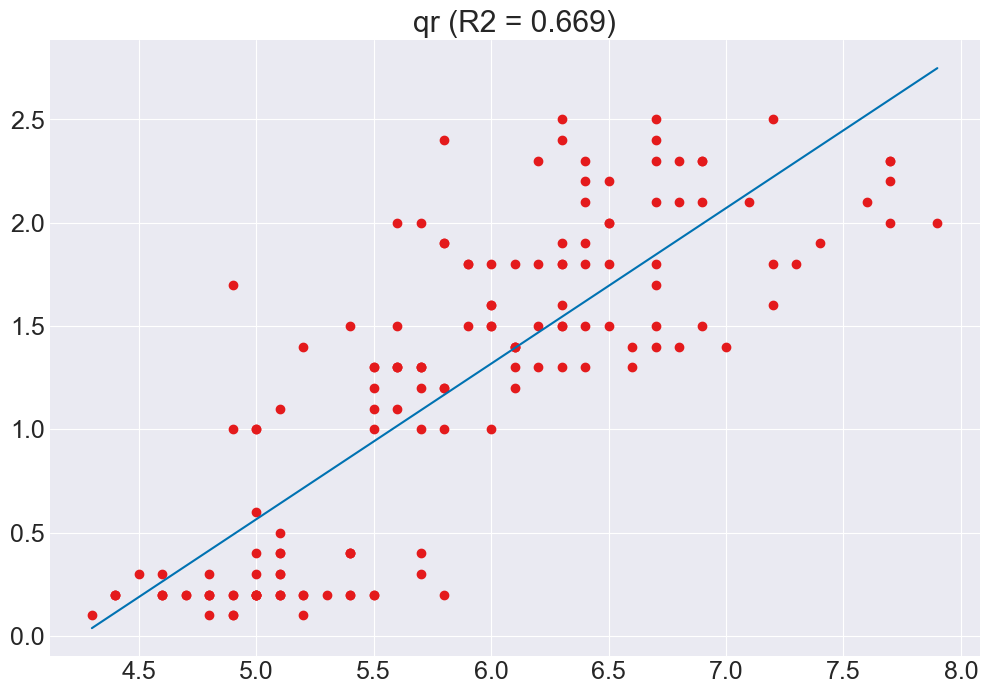

In [30]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'qr')
lin_reg_qr.show()

**Question 4:** How do your results compare to the built-in SciPy solver? Is this what you expected? Why or why not?

**Answer 4:** They are the same. This was I expected since both estimate using the same overall process.

### Task 4b. Compare performance of the linear regression methods

- In the cell below, load in the brain network `brain.csv` dataset.
- Create `Data` and `LinearRegression` objects.
- Load in the list of variable names in the brain dataset (62)
- Do multiple linear regressions, separately for each of the linear regression methods that you have implemented (including `scipy`): Set all brain data variables except for the last one as the independent variables, the last variable is the depenendent variable.
- Compute and print the mean squared error (MSE) in the predictions made by each linear regression model and the actual y values.

In [38]:
brain_data = data.Data("data\\brain.csv")
brain_lr = linear_regression.LinearRegression(brain_data)

vars = brain_data.get_headers()
ind_vars = vars[:61]
dep_var = vars[-1]

In [39]:
brain_lr.linear_regression(ind_vars, dep_var, 'scipy')
print(f"scipy MSE : {brain_lr.mse}")

scipy MSE : 1.0145011893932979e-25


In [40]:
brain_lr.linear_regression(ind_vars, dep_var, 'normal')
print(f"normal MSE : {brain_lr.mse}")

normal MSE : 636806.8022571134


In [41]:
brain_lr.linear_regression(ind_vars, dep_var, 'qr')
print(f"qr MSE : {brain_lr.mse}")

qr MSE : 1.0391579803321464e-24


**Question 5:** What are the mean squared errors for each of the regression methods on the brain data? Which method(s) do best and which do the worst **and why**?

**Answer 5:** both the scipy and the QR methods worked pretty well, with the QR having the smallest error. The normal method didn't work great, resulting in a high MSE. This is due to the use of matrix inverses, which are very sensitive to small changes in data.

## Task 5: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit data with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a simple linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$ 

Complete the following steps to add support for polynomial regression in your `LinearRegression` class.

### 5a. Build the polynomial matrix of the independent variable

The polynomial matrix contains the independent variable raised to a different power in each column. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).

**TODO:**
Implement and test `LinearRegression::make_polynomial_matrix` (*helper method*) that takes care of raising the independent variable samples to different powers.

##### Test `make_polynomial_matrix`

In [42]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 5b. Add support for polynomial regression

This can be performed in 3 steps:

1. Implement the `LinearRegression::polynomial_regression` method to perform the polynomial regression (*alternate option: you may instead update your `linear_regression` method. If you decide to go this route, add a keyword argument for the polynomial degree with a default value of 1 to preserve compatability with regular linear regression.*).
    - I suggest using your QR solver, but you could use any of the ones you have implemented.
2. Update `LinearRegression::predict`: Run `make_polynomial_matrix` on the "A" matrix that enters into the computation $y = Ac$ if `self.p > 1`.
3. Add support for plotting polynomials in `LinearRegression::scatter` by generalizing the plotted regression line to a regression polynomial if `self.p > 1`:
    - Getting your polynomial "x" values: Run `make_polynomial_matrix` on your evenly-spaced line sample points. To get the shapes to work out, you may need to add a trailing singleton dimension to your "x" sample points. For example, if you have 1000 "x" sample points, make the shape `(1000, 1)` rather than `(1000,)`.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.

*There is no explicit test code here — visualizing the fit in the next subtask will help you debug!*

### 5c. Run a polynomial regression

In this subtask, you will debug your polynomial regression implementation and experiment fitting some data with it.

#### Test: Polynomial regression with linear model ($p = 1$)

- In the cell below, fit the `poly_data.csv` dataset using polynomial regression where the polynomial degree $p = 1$. Use your QR solver.
- Use `scatter` to plot the results.
- Print out the mean squared error.

The plot created by running the below cell should "look right" to you.

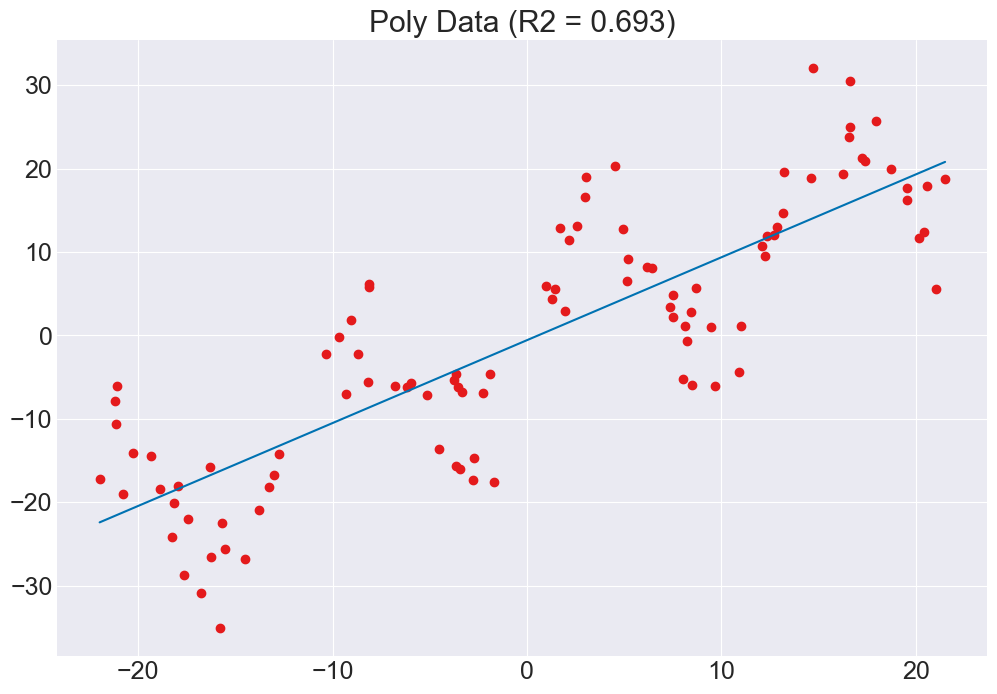

In [104]:
poly_data = data.Data('data\poly_data.csv')
lin_reg = linear_regression.LinearRegression(poly_data)
lin_reg.poly_regression('X', 'Y', 1)
lin_reg.scatter('X', 'Y', 'Poly Data')

#### Test: polynomial regression with high degree polynomials

Repeat the steps from the $p = 1$ test above in the cell below, but this time try $p = 15$. 

*Your regression fit should not be a line!*

(100, 2)
(2, 1)


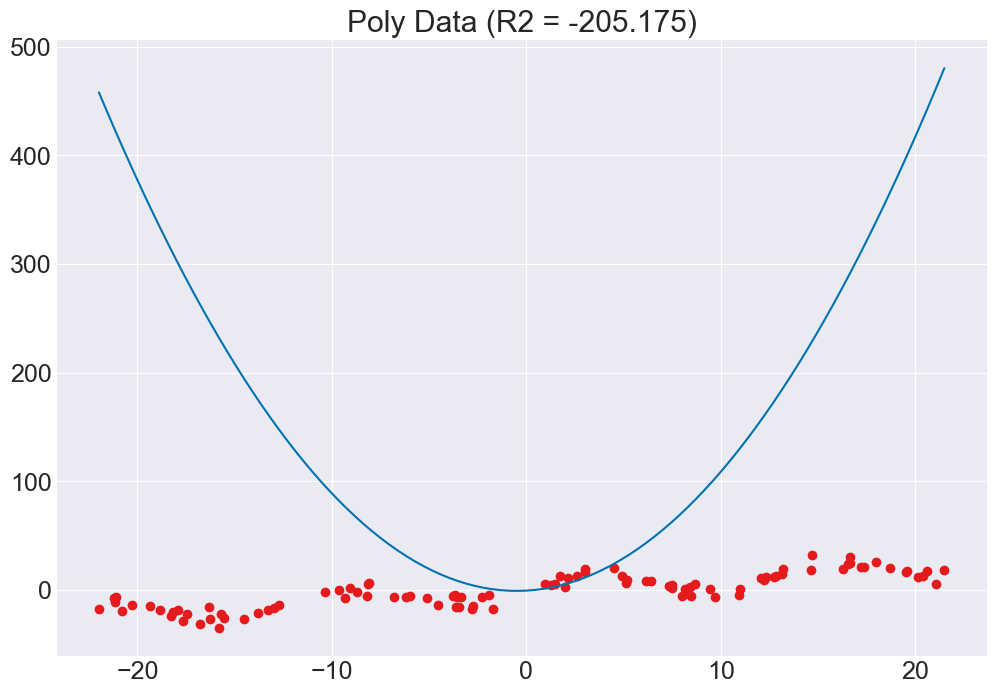

In [113]:
poly_data = data.Data('data\poly_data.csv')
lin_reg = linear_regression.LinearRegression(poly_data)
lin_reg.poly_regression('X', 'Y', 2)
lin_reg.scatter('X', 'Y', 'Poly Data')

**Question 6:** Describe the fit compared to `p=1` — is it better or worse? Why?

**Question 7:** Describe what happens visually and in terms of the $R^2$ and MSE values as you experiment with the polynomial degree between 1 and 15.

**Answer 6:** 

**Answer 7:**

## Task 6: Overfitting

In this task, you will experiment with how polynomial regression generals to data not used to fit the regression model.

### 6a. Create fit and validation sets

The `poly_data.csv` dataset has 100 samples ($N=100$). In the cell below, split these samples into two separate "datasets" and create 2 `Data` objects representing:
- The first 50% of samples will be used to fit the regression model (i.e. run linear regression on these samples). We will call this the **fit set** (data used to fit the regression).
- The second 50% of samples will be set aside and only used to check how well the fitted regression generalizes to new data. We will call this the **validation set**.

The data samples are already shuffled.

*Hint: There is a helpful `Data` method for paring down a dataset into a certain range of samples.*

Printing the `Data` object storing the fit set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    2.147	11.382
    9.465	1.034
    4.52	20.251
    1.974	2.89
    -3.358	-6.809

    -------------------------------

Printing the `Data` object storing the validation set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    -3.65	-4.658
    9.69	-6.107
    -21.986	-17.271
    -8.694	-2.22
    -15.536	-25.608

    -------------------------------

### 6b. Check fit generalization on validation set

Here is the process for checking how well your fitted linear regression model generalizes to the validation data:
1. Create `Data` objects for both the fit and validation data sets (*as you have already done*).
2. Run linear regression on the fit set.
3. Create a new `LinearRegression` object associated with the validation data.
4. Copy over the fitted slope and intercept coefficients associated with the fit set to the validation set `LinearRegression` object.
5. Create a scatterplot by calling `scatter` to show the validation data and the regression curve that uses the coefficients fitted on the fit dataset (copied over in Step 4).
6. Calculate and report fit statistics (e.g. MSE, $R^2$).

Before doing this, implement the following methods to help you copy over the fitted slope, intercept and other data from your fit set `LinearRegression` object:

- `get_fitted_slope`: return the fitted regression slopes.
- `get_fitted_intercept`: return the fitted regression intercept.
- `initialize(ind_vars, dep_var, slope, intercept, p)`: set fields based on passed in parameter values.

#### Check overfitting with $p = 15$ polynomial regression model

In the cell below:

1. Fit a polynomial regression model with $p = 15$ on the fit set.
2. Create 2 scatter plots:
    - Showing the fit set and regression curve fitted to it.
    - Showing the validation set and regression curve that uses the fitted coefficients to the **fit set**.
3. Compute and print the MSE for both the fit and validation sets.

Use the 6 step process above to guide you through the setup.

**Question 8:** Describe how the fitted coefficients obtained for the fit set generalize to the validation set. Do they do a good or bad job? Why?

**Question 9:** Does the generalization improve or worsen for polynomial degrees < 15? Are Back up your observations with numbers (e.g. MSE).

**Question 10:** Are there any values/ranges of polynomial degrees that generalize acceptably to the validation set? Why do you think so?

**Question 11:** What happens when you increase the polynomial degree much above 15? Why do you think this happens? Back up your observations with numbers (e.g. MSE).

**Answer 8:** 

**Answer 9:**

**Answer 10:** 

**Answer 11:** 

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

### 2. Linear regression algorithm comparison

- Compare the linear regression methods that you implemented on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`). [This website](https://real-statistics.com/regression/confidence-and-prediction-intervals/) should be a helpful reference.

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

### 5. Stepwise linear regression

- Implement the stepwise linear regression discussed in class where you add variables to the regression model one-by-one in a greedy fashion: each variable added out of the available ones not already entered in the regression should result in the largest increase in the adjusted $R^2$ value on the validation data.